# Performance of the GREGWT algorithm

M. Esteban Muñoz H. <marcelo.hidalgo@hcu-hamburg.de>

HafenCity Universität – Infrastrukturplanung und Stadttechnik

#Table of Contents
* [1. The data used to comparte the performance of the GREGWT algorithm](#1.-The-data-used-to-comparte-the-performance-of-the-GREGWT-algorithm)
	* [1.1 Input data](#1.1-Input-data)
		* [1.1.1 The micro census data](#1.1.1-The-micro-census-data)
		* [1.1.2 The census data](#1.1.2-The-census-data)
	* [1.2 Simulation results](#1.2-Simulation-results)
* [2. Weight distance](#2.-Weight-distance)
	* [2.1 Chi-squared distance](#2.1-Chi-squared-distance)
	* [2.2 Absolute weight distance](#2.2-Absolute-weight-distance)
* [3. Weights difference](#3.-Weights-difference)
* [4. Total Absolute Error](#4.-Total-Absolute-Error)
	* [4.1 Comparison of marginal totals between implementations](#4.1-Comparison-of-marginal-totals-between-implementations)
	* [4.2 Comparison of marginal totals between simulations and census data (TAE)](#4.2-Comparison-of-marginal-totals-between-simulations-and-census-data-%28TAE%29)
	* [4.3 Total absolute error of the R and SAS implementations](#4.3-Total-absolute-error-of-the-R-and-SAS-implementations)
		* [4.3.1 Total absolute error $TAE$ of the individual constrains for the diffrent simulations](#4.3.1-Total-absolute-error-$TAE$-of-the-individual-constrains-for-the-diffrent-simulations)
		* [4.3.2 Sum of the total absolute error $TAE$ for all simulation areas](#4.3.2-Sum-of-the-total-absolute-error-$TAE$-for-all-simulation-areas)
* [5. Percentage Absolute Error](#5.-Percentage-Absolute-Error)
	* [5.1 Percentage absolute error $PSAE$ for the different simulations](#5.1-Percentage-absolute-error-$PSAE$-for-the-different-simulations)
	* [5.2 Comparison of the sum of the percentage absolute error $PSAE$](#5.2-Comparison-of-the-sum-of-the-percentage-absolute-error-$PSAE$)
* [6. Comparison of used categories](#6.-Comparison-of-used-categories)


# 1. The data used to comparte the performance of the GREGWT algorithm

For this comparison I use two datasets, both datasets are the result from a simulation with the same input data. Both datasets represent the estimated new weights for 4 small areas using:

1. An implementation of the GREGWT algorithm in he **SAS** language; and
2. An implementation of the GREGWT algorithm in the **R** language.

First I compare the resulting weights from both datasets and in a second step I compare the Total Absolute Error $TAE$ and the Percentage Absolute Error $PSAE$.

In [1]:
# load some libraries
import pandas as pd # library for data analysis
import seaborn as sns # statistical graphics in Python
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
%matplotlib inline
colors = plt.rcParams['axes.color_cycle']

## 1.1 Input data

The input data consists of two datasets:

1. A individual level survey; and
2. Census records available at a district level, which correspond to the "Nomenclature of Territorial Units for Statistics" 3 **(NUTS 3)** aggregation level.

### 1.1.1 The micro census data

In [2]:
survey = pd.read_csv("./Mikrozensus-2010-cat.csv", index_col=0, thousands=",")
col = survey.columns[0:-1]
for c in col: survey[c] = survey[c].astype('category')

In [3]:
survey.head()

,Age,Marital.Status,Household.Size,Heat.Expenditure,Weights
1,65...74,Divorced,1.person,NaN,90173
2,40...49,Married,4.persons,NaN,119987
3,40...49,Married,4.persons,NaN,119987
4,18...24,Single,4.persons,NaN,119987
5,75.and.over,Widowed,4.persons,NaN,119987


**Table 1:** Description of the used survey data

This survey data contains $23374$ records and corresponds to the $3\%$ of the official micro census data for scientific use ($1\%$ of the total German population). This data set represents $0.03\%$ of the German population. The file can be downloaded from [here](http://www.forschungsdatenzentrum.de/bestand/mikrozensus/cf/2002/) the official page of the German statistical office.

In [4]:
categories = pd.DataFrame({"number of ctaegories": [len(survey[col].cat.categories) for col in survey.columns[1:-1]],
                           "categories": [[survey[col].cat.categories] for col in survey.columns[1:-1]]},
                          index=survey.columns[1:-1])
categories.loc["Weights"] = ["numeric", "/"]

In [5]:
categories

,categories,number of ctaegories
Marital.Status,"[[Civil.union.terminated, Divorced, Married, P...",6
Household.Size,"[[1.person, 2.persons, 3.persons, 4.persons, 5...",6
Heat.Expenditure,"[[100...150, 150...200, 200...300, 300...400, ...",6
Weights,numeric,/


**Table 2:** Number of categories of the survey variables

### 1.1.2 The census data

In [6]:
census = pd.read_csv("./Zensus-2011-clean.csv", index_col="Area.Code")
census = census.drop('Unnamed: 0', 1)
census = census.loc[[2, 11, 4011, 4012]]
total_pop = pd.read_csv("./total_pop.csv", index_col="Area.ID")
total_pop = total_pop.drop('Unnamed: 0', 1)
total_pop = total_pop.loc[[2, 11, 4011, 4012]]
total_pop.columns = ["pop"]
census = pd.merge(census, total_pop, left_index=True, right_index=True)

In [7]:
census.head()

,Under.3,3...5,6...14,15...17,18...24,25...29,30...39,40...49,50...64,65...74,...,Divorced,Party.to.a.civil.union,Civil.union.terminated,1.person,2.persons,3.persons,4.persons,5.persons,6.or.more.people,pop
Area.Code,,,,,,,,,,,,,,,,,,,,,
2,47757,45575,132476,42239,138325,136313,258238,280671,301189,178471,...,143354,3353,412,400440,528441,303930,264486,103963,67650,1706696
11,94867,86753,239171,73592,271412,263554,464285,539688,624691,376088,...,333989,8709,930,860542,1092332,582501,427341,163306,119185,3292365
4011,12996,12714,41156,14431,49366,39910,68692,85587,104168,62164,...,48267,795,60,121056,172867,98675,84504,33651,22602,542707
4012,2643,2822,8919,3199,9296,6757,12021,16093,22277,13100,...,9723,89,15,26444,34910,18396,15138,6721,4994,108156


**Table 3:** Description of the census data

In [8]:
census.loc[:,"Under.3":"75.and.over"].sum(axis=1)

Area.Code
2       1706696
11      3292365
4011     542707
4012     108156
dtype: int64

The census data listed above comes from the census 2011 and can be access [here](https://ergebnisse.zensus2011.de/). All the results from the census can be access through the web portal. Unfortunately there is no API to access the data remotely.

## 1.2 Simulation results

In [9]:
#rgwData = pd.read_csv("./Simulation-Result-weights15.csv", index_col=0) # original [SAS cat]
#rgwData = pd.read_csv("./Simulation-Result-weights16.csv", index_col=0) # population alignment [SAS cat]
#rgwData = pd.read_csv("./Simulation-Result-weights18.csv", index_col=0) # population alignment [new SAS cat] optimal cat
#rgwData = pd.read_csv("./Simulation-Result-weights19.csv", index_col=0) # population alignment [new SAS cat] sas cat
rgwData = pd.read_csv("./Simulation-Result-weights20.csv", index_col=0) # population alignment [new SAS cat] sas cat
#rgwData = pd.read_csv("./Simulation-Result-weights21.csv", index_col=0) # minamal PSAE
ipfData = pd.read_csv("./Simulation-Result-ipf.csv", index_col=0)
#rgwData = pd.read_csv("./Simulation-Result-ipf.csv", index_col=0)
#sasData = pd.read_csv("./areawts_150206_wpopmin1class.csv",index_col="Pers_ID", usecols=[0,2,3,4,5])
sasData = pd.read_csv("./areawts_150206_withpop.csv",index_col="Pers_ID", usecols=[0,2,3,4,5])
#sasData = pd.read_csv("./areawts_150119.csv",index_col="Pers_ID", usecols=[0,2,3,4,5])

In [10]:
plot_data = pd.merge(rgwData, sasData, left_index=True, right_index=True)
plot_data = pd.merge(plot_data, ipfData, left_index=True, right_index=True)
plot_data.columns = ['Weights R area 02',   'Weights R area 11',   'Weights R area 4011',   'Weights R area 4012',
                     'Weights SAS area 02', 'Weights SAS area 11', 'Weights SAS area 4011', 'Weights SAS area 4012',
                     'Weights IPF area 02', 'Weights IPF area 11', 'Weights IPF area 4011', 'Weights IPF area 4012']

In [11]:
plot_data.to_csv("results_merged.csv")

In [12]:
plot_data.head()

,Weights R area 02,Weights R area 11,Weights R area 4011,Weights R area 4012,Weights SAS area 02,Weights SAS area 11,Weights SAS area 4011,Weights SAS area 4012,Weights IPF area 02,Weights IPF area 11,Weights IPF area 4011,Weights IPF area 4012
1,80.044798,194.128895,27.633426,5.944768,80.044798,193.978284,27.521232,5.924388,79.434485,197.643758,27.752008,6.078195
2,59.225051,85.885031,19.430718,3.432242,59.225051,85.854515,19.455628,3.428113,60.707081,92.271993,19.681740,3.550656
3,59.225051,85.885031,19.430718,3.432242,59.225051,85.854515,19.455628,3.428113,60.707081,92.271993,19.681740,3.550656
4,76.039523,129.754047,29.136628,4.350349,76.039523,129.819182,28.986772,4.359163,74.669784,125.042120,28.379312,4.297351
5,70.084494,92.603630,32.681989,5.272939,70.084494,93.172527,32.312744,5.349921,69.923674,100.678268,32.264307,4.994161


**Table 4:** Merged data for comparison

# 2. Weight distance

## 2.1 Chi-squared distance

$$
\begin{equation}
    Chi_i = \sum_j^m \frac{\left( w_j - d_j\right)^2 }{2d_j}
\end{equation}
$$

In [13]:
population_totals = pd.DataFrame(
    {"Age":census.loc[:,"Under.3":"75.and.over"].sum(axis=1),
     "Marital.Status":census.loc[:,"Single":"Civil.union.terminated"].sum(axis=1),
     "Household.Size":census.loc[:,"1.person":"6.or.more.people"].sum(axis=1)})
population_totals["mean"] = population_totals.mean(axis=1)

In [14]:
population_totals.head()

,Age,Household.Size,Marital.Status,mean
Area.Code,,,,
2,1706696,1668910,1706490,1694032.000000
11,3292365,3245207,3291626,3276399.333333
4011,542707,533355,542460,539507.333333
4012,108156,106603,108056,107605.000000


In [15]:
population_totals.Age = survey.Weights * population_totals.Age / sum(survey.Weights)

In [16]:
chi_dis = pd.DataFrame({
"R 02":    (plot_data['Weights R area 02']     - population_totals.Age[2]   )**2 / (2 * population_totals.Age[2]   ),
"R 11":    (plot_data['Weights R area 11']     - population_totals.Age[11]  )**2 / (2 * population_totals.Age[11]  ),
"R 4011":  (plot_data['Weights R area 4011']   - population_totals.Age[4011])**2 / (2 * population_totals.Age[4011]),
"R 4012":  (plot_data['Weights R area 4012']   - population_totals.Age[4012])**2 / (2 * population_totals.Age[4012]),
"SAS 02":  (plot_data['Weights SAS area 02']   - population_totals.Age[2]   )**2 / (2 * population_totals.Age[2]   ),
"SAS 11":  (plot_data['Weights SAS area 11']   - population_totals.Age[11]  )**2 / (2 * population_totals.Age[11]  ),
"SAS 4011":(plot_data['Weights SAS area 4011'] - population_totals.Age[4011])**2 / (2 * population_totals.Age[4011]),
"SAS 4012":(plot_data['Weights SAS area 4012'] - population_totals.Age[4012])**2 / (2 * population_totals.Age[4012]),
"IPF 02":  (plot_data['Weights IPF area 02']   - population_totals.Age[2]   )**2 / (2 * population_totals.Age[2]   ),
"IPF 11":  (plot_data['Weights IPF area 11']   - population_totals.Age[11]  )**2 / (2 * population_totals.Age[11]  ),
"IPF 4011":(plot_data['Weights IPF area 4011'] - population_totals.Age[4011])**2 / (2 * population_totals.Age[4011]),
"IPF 4012":(plot_data['Weights IPF area 4012'] - population_totals.Age[4012])**2 / (2 * population_totals.Age[4012])
})

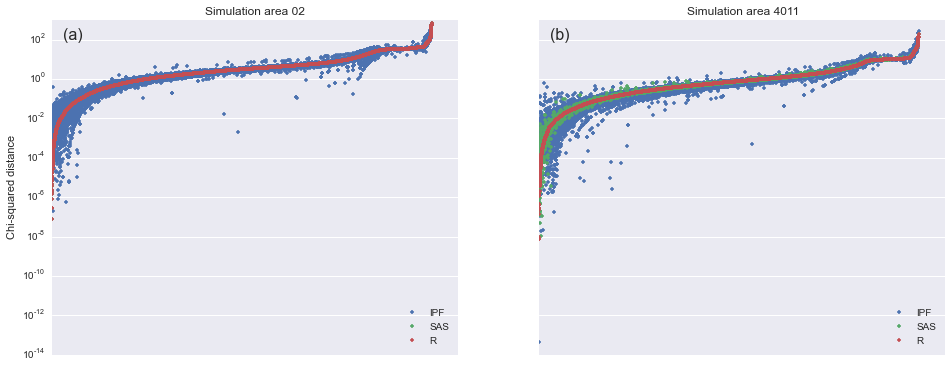

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6), sharey=True)

chi_dis = chi_dis.sort(["R 02"])
ax1.plot(chi_dis["IPF 02"], '.', label='IPF')
ax1.plot(chi_dis["SAS 02"], '.', label='SAS')
ax1.plot(chi_dis["R 02"], '.', label='R')
ax1.set_yscale('log')
ax1.set_ylabel('Chi-squared distance')
ax1.legend(loc=4)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.text(0.03, 0.94, "(a)", fontsize=16, transform = ax1.transAxes)
ax1.set_title("Simulation area 02");

chi_dis = chi_dis.sort(["R 4011"])
ax2.plot(chi_dis["IPF 4011"], '.', label='IPF')
ax2.plot(chi_dis["SAS 4011"], '.', label='SAS')
ax2.plot(chi_dis["R 4011"], '.', label='R')
ax2.set_yscale('log')
ax2.legend(loc=4)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.text(0.03, 0.94, "(b)", fontsize=16, transform = ax2.transAxes)
ax2.set_title("Simulation area 4011");
plt.savefig("FIGURES/chisquared.pdf", format="pdf", bbox_inches='tight')

**Figure 1.0:** Chi-squared distance between esimated and design weights for simulation area **02** and **4011**.

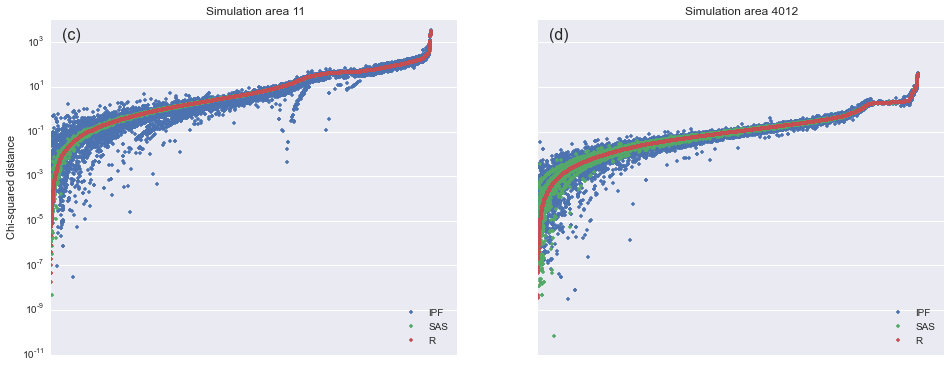

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6), sharey=True)

chi_dis = chi_dis.sort(["R 11"])
ax1.plot(chi_dis["IPF 11"], '.', label='IPF')
ax1.plot(chi_dis["SAS 11"], '.', label='SAS')
ax1.plot(chi_dis["R 11"], '.', label='R')
ax1.set_yscale('log')
ax1.set_ylabel('Chi-squared distance')
ax1.legend(loc=4)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.text(0.03, 0.94, "(c)", fontsize=16, transform = ax1.transAxes)
ax1.set_title("Simulation area 11");

chi_dis = chi_dis.sort(["R 4012"])
ax2.plot(chi_dis["IPF 4012"], '.', label='IPF')
ax2.plot(chi_dis["SAS 4012"], '.', label='SAS')
ax2.plot(chi_dis["R 4012"], '.', label='R')
ax2.set_yscale('log')
ax2.legend(loc=4)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.text(0.03, 0.94, "(d)", fontsize=16, transform = ax2.transAxes)
ax2.set_title("Simulation area 4012");
plt.savefig("FIGURES/chisquared2.pdf", format="pdf", bbox_inches='tight')

**Figure 1.0:** Chi-squared distance between esimated and design weights for simulation area **11** and **4012**.

In [19]:
pd.DataFrame({"SAS":["{:0.2E}".format(chi_dis.sum()["SAS 02"]),
                     "{:0.2E}".format(chi_dis.sum()["SAS 11"]),
                     "{:0.2E}".format(chi_dis.sum()["SAS 4011"]),
                     "{:0.2E}".format(chi_dis.sum()["SAS 4012"])
                     ],
              "R":  ["{:0.2E}".format(chi_dis.sum()["R 02"]),
                     "{:0.2E}".format(chi_dis.sum()["R 11"]),
                     "{:0.2E}".format(chi_dis.sum()["R 4011"]),
                     "{:0.2E}".format(chi_dis.sum()["R 4012"])
                     ],
              "IPF":["{:0.2E}".format(chi_dis.sum()["IPF 02"]),
                     "{:0.2E}".format(chi_dis.sum()["IPF 11"]),
                     "{:0.2E}".format(chi_dis.sum()["IPF 4011"]),
                     "{:0.2E}".format(chi_dis.sum()["IPF 4012"])
                     ]},
             index=["Area 02", "Area 11", "Area 4011", "Area 4012"])

,IPF,R,SAS
Area 02,2.28E+05,2.26E+05,2.26E+05
Area 11,7.40E+05,7.36E+05,7.36E+05
Area 4011,6.39E+04,6.36E+04,6.35E+04
Area 4012,1.21E+04,1.21E+04,1.21E+04


**Table 5:** Sum Chi-squared distance for al simulation methods and all areas

In [20]:
pd.DataFrame({"SAS":["{:0.2E}".format(chi_dis.mean()["SAS 02"]),
                     "{:0.2E}".format(chi_dis.mean()["SAS 11"]),
                     "{:0.2E}".format(chi_dis.mean()["SAS 4011"]),
                     "{:0.2E}".format(chi_dis.mean()["SAS 4012"])
                     ],
              "R":  ["{:0.2E}".format(chi_dis.mean()["R 02"]),
                     "{:0.2E}".format(chi_dis.mean()["R 11"]),
                     "{:0.2E}".format(chi_dis.mean()["R 4011"]),
                     "{:0.2E}".format(chi_dis.mean()["R 4012"])
                     ],
              "IPF":["{:0.2E}".format(chi_dis.mean()["IPF 02"]),
                     "{:0.2E}".format(chi_dis.mean()["IPF 11"]),
                     "{:0.2E}".format(chi_dis.mean()["IPF 4011"]),
                     "{:0.2E}".format(chi_dis.mean()["IPF 4012"])
                     ]},
             index=["Area 02", "Area 11", "Area 4011", "Area 4012"])

,IPF,R,SAS
Area 02,9.73E+00,9.65E+00,9.65E+00
Area 11,3.17E+01,3.15E+01,3.15E+01
Area 4011,2.73E+00,2.72E+00,2.72E+00
Area 4012,5.19E-01,5.18E-01,5.18E-01


**Table 5b:** mean Chi-squared distance for al simulation methods and all areas

## 2.2 Absolute weight distance

In [21]:
abs_dis = pd.DataFrame({
    "R 02":    abs(plot_data['Weights R area 02']     - population_totals.Age[2]),
    "R 11":    abs(plot_data['Weights R area 11']     - population_totals.Age[11]),
    "R 4011":  abs(plot_data['Weights R area 4011']   - population_totals.Age[4011]),
    "R 4012":  abs(plot_data['Weights R area 4012']   - population_totals.Age[4012]),
    "SAS 02":  abs(plot_data['Weights SAS area 02']   - population_totals.Age[2]),
    "SAS 11":  abs(plot_data['Weights SAS area 11']   - population_totals.Age[11]),
    "SAS 4011":abs(plot_data['Weights SAS area 4011'] - population_totals.Age[4011]),
    "SAS 4012":abs(plot_data['Weights SAS area 4012'] - population_totals.Age[4012]),
    "IPF 02":  abs(plot_data['Weights IPF area 02']   - population_totals.Age[2]),
    "IPF 11":  abs(plot_data['Weights IPF area 11']   - population_totals.Age[11]),
    "IPF 4011":abs(plot_data['Weights IPF area 4011'] - population_totals.Age[4011]),
    "IPF 4012":abs(plot_data['Weights IPF area 4012'] - population_totals.Age[4012])
})

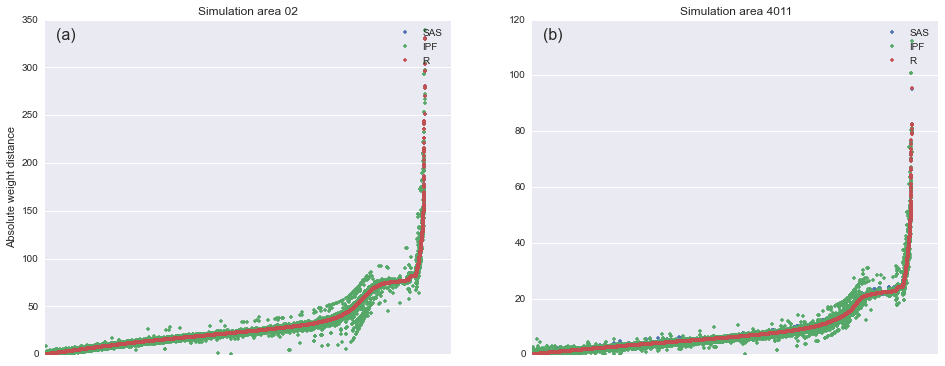

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))#, sharey=True)

abs_dis = abs_dis.sort(["R 02"])
ax1.plot(abs_dis["SAS 02"], '.', label='SAS')
ax1.plot(abs_dis["IPF 02"], '.', label='IPF')
ax1.plot(abs_dis["R 02"], '.', label='R')
#ax1.set_yscale('log')
ax1.set_ylabel('Absolute weight distance')
ax1.legend(loc=1)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.text(0.03, 0.94, "(a)", fontsize=16, transform = ax1.transAxes)
ax1.set_title("Simulation area 02");

abs_dis = abs_dis.sort(["R 4011"])
ax2.plot(abs_dis["SAS 4011"], '.', label='SAS')
ax2.plot(abs_dis["IPF 4011"], '.', label='IPF')
ax2.plot(abs_dis["R 4011"], '.', label='R')
#ax2.set_yscale('log')
ax2.legend(loc=1)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.text(0.03, 0.94, "(b)", fontsize=16, transform = ax2.transAxes)
ax2.set_title("Simulation area 4011");
plt.savefig("FIGURES/abschisquared.pdf", format="pdf", bbox_inches='tight')

In [23]:
pd.DataFrame({"SAS":["{:0.2E}".format(abs_dis.sum()["SAS 02"]),
                     "{:0.2E}".format(abs_dis.sum()["SAS 11"]),
                     "{:0.2E}".format(abs_dis.sum()["SAS 4011"]),
                     "{:0.2E}".format(abs_dis.sum()["SAS 4012"])
                     ],
              "R":  ["{:0.2E}".format(abs_dis.sum()["R 02"]),
                     "{:0.2E}".format(abs_dis.sum()["R 11"]),
                     "{:0.2E}".format(abs_dis.sum()["R 4011"]),
                     "{:0.2E}".format(abs_dis.sum()["R 4012"])
                     ],
              "IPF":["{:0.2E}".format(abs_dis.sum()["IPF 02"]),
                     "{:0.2E}".format(abs_dis.sum()["IPF 11"]),
                     "{:0.2E}".format(abs_dis.sum()["IPF 4011"]),
                     "{:0.2E}".format(abs_dis.sum()["IPF 4012"])
                     ]},
             index=["Area 02", "Area 11", "Area 4011", "Area 4012"])

,IPF,R,SAS
Area 02,6.96E+05,7.02E+05,7.02E+05
Area 11,1.32E+06,1.34E+06,1.34E+06
Area 4011,1.91E+05,1.94E+05,1.94E+05
Area 4012,3.46E+04,3.49E+04,3.49E+04


In [24]:
pd.DataFrame({"SAS":["{:0.2E}".format(abs_dis.min()["SAS 02"]),
                     "{:0.2E}".format(abs_dis.min()["SAS 11"]),
                     "{:0.2E}".format(abs_dis.min()["SAS 4011"]),
                     "{:0.2E}".format(abs_dis.min()["SAS 4012"])
                     ],
              "R":  ["{:0.2E}".format(abs_dis.min()["R 02"]),
                     "{:0.2E}".format(abs_dis.min()["R 11"]),
                     "{:0.2E}".format(abs_dis.min()["R 4011"]),
                     "{:0.2E}".format(abs_dis.min()["R 4012"])
                     ],
              "IPF":["{:0.2E}".format(abs_dis.min()["IPF 02"]),
                     "{:0.2E}".format(abs_dis.min()["IPF 11"]),
                     "{:0.2E}".format(abs_dis.min()["IPF 4011"]),
                     "{:0.2E}".format(abs_dis.min()["IPF 4012"])
                     ]},
             index=["Area 02", "Area 11", "Area 4011", "Area 4012"])

,IPF,R,SAS
Area 02,5.89E-03,3.61E-03,3.61E-03
Area 11,2.64E-03,2.01E-03,1.04E-03
Area 4011,1.44E-06,5.95E-04,7.05E-04
Area 4012,1.78E-04,1.83E-04,2.62E-05


# 3. Weights difference

In [25]:
import seaborn as sns

In [26]:
#fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)
#g = sns.jointplot(x="Weights SAS area 02", y="Weights IPF area 02", data=plot_data, kind="reg")

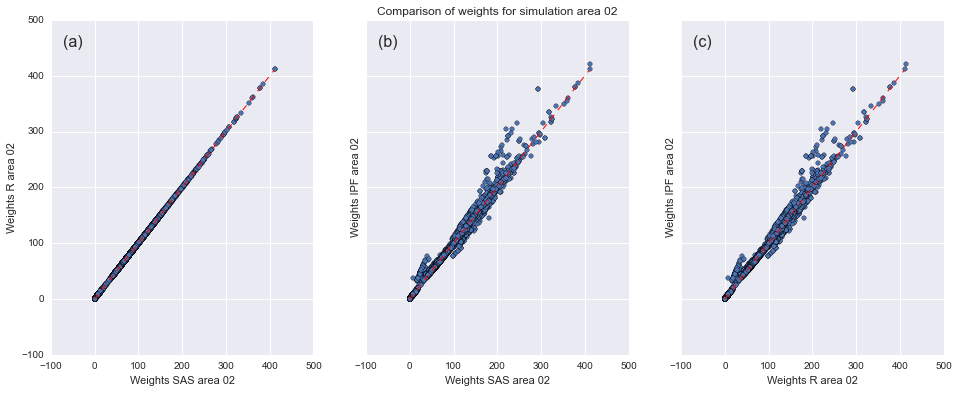

In [27]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)

plot_data.plot(kind="scatter", x="Weights SAS area 02", y="Weights R area 02", ax=ax1)
x1 = np.arange(min(plot_data["Weights SAS area 02"]), max(plot_data["Weights SAS area 02"]), 10)
ax1.plot(x1, x1, linestyle='--', color="red", linewidth=1)
ax1.text(0.05, 0.92, "(a)", fontsize=16, transform = ax1.transAxes)

plot_data.plot(kind="scatter", x="Weights SAS area 02", y="Weights IPF area 02", ax=ax2)
x2 = np.arange(min(plot_data["Weights SAS area 02"]), max(plot_data["Weights SAS area 02"]), 10)
ax2.plot(x2, x2, linestyle='--', color="red", linewidth=1)
ax2.text(0.05, 0.92, "(b)", fontsize=16, transform = ax2.transAxes)

plot_data.plot(kind="scatter", x="Weights R area 02", y="Weights IPF area 02", ax=ax3)
x3 = np.arange(min(plot_data["Weights SAS area 02"]), max(plot_data["Weights SAS area 02"]), 10)
ax3.plot(x3, x3, linestyle='--', color="red", linewidth=1)
ax3.text(0.05, 0.92, "(c)", fontsize=16, transform = ax3.transAxes)
title = 'Comparison of weights for simulation area 02'

ax2.set_title(title)
plt.savefig("FIGURES/weights02.pdf", format="pdf", bbox_inches='tight')

**Figure 1.a:** Comparison between estimated weights of the GREGWT **SAS** and **R** implementations and **IPF** for simulation area 02.

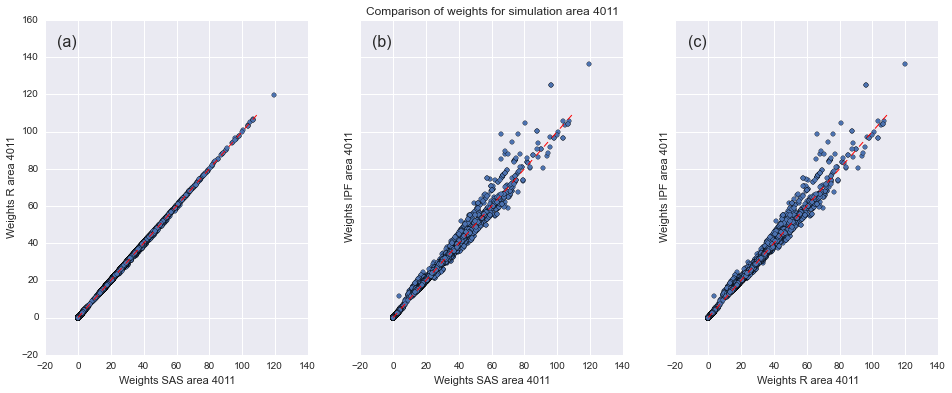

In [28]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)

plot_data.plot(kind="scatter", x="Weights SAS area 4011", y="Weights R area 4011", ax=ax1)
x1 = np.arange(min(plot_data["Weights SAS area 4011"]), max(plot_data["Weights SAS area 4011"]), 10)
ax1.plot(x1, x1, linestyle='--', color="red", linewidth=1)
ax1.text(0.05, 0.92, "(a)", fontsize=16, transform = ax1.transAxes)

plot_data.plot(kind="scatter", x="Weights SAS area 4011", y="Weights IPF area 4011", ax=ax2)
x2 = np.arange(min(plot_data["Weights SAS area 4011"]), max(plot_data["Weights SAS area 4011"]), 10)
ax2.plot(x2, x2, linestyle='--', color="red", linewidth=1)
ax2.text(0.05, 0.92, "(b)", fontsize=16, transform = ax2.transAxes)

plot_data.plot(kind="scatter", x="Weights R area 4011", y="Weights IPF area 4011", ax=ax3)
x3 = np.arange(min(plot_data["Weights SAS area 4011"]), max(plot_data["Weights SAS area 4011"]), 10)
ax3.plot(x3, x3, linestyle='--', color="red", linewidth=1)
ax3.text(0.05, 0.92, "(c)", fontsize=16, transform = ax3.transAxes)

title = 'Comparison of weights for simulation area 4011'
ax2.set_title(title)
plt.savefig("FIGURES/weights4011.pdf", format="pdf", bbox_inches='tight')

**Figure 1.b:** Comparison between estimated weights of the GREGWT **SAS** and **R** implementations and **IPF** for simulation area 4011.

##Relative absolute weight diference

$$
\begin{equation}
    WD_j = \left|\frac{w_{i,j}^R}{pop_j} - \frac{w_{i,j}^{SAS}}{pop_j} \right| \div n
\end{equation}
$$

In [29]:
def getDiff(a, b, pop):
    D = abs(plot_data[a].div(pop) - plot_data[b].div(pop)).mean()
    return(D)

In [30]:
WD = pd.DataFrame({
        "IPF --- SAS": [getDiff("Weights SAS area 02", "Weights IPF area 02", population_totals.loc[2, "Age"]),
                    getDiff("Weights SAS area 11", "Weights IPF area 11", population_totals.loc[11, "Age"]),
                    getDiff("Weights SAS area 4011", "Weights IPF area 4011", population_totals.loc[4011, "Age"]),
                    getDiff("Weights SAS area 4012", "Weights IPF area 4012", population_totals.loc[4012, "Age"])],
        #"R - IPF": [getDiff("Weights R area 02", "Weights IPF area 02"),
        #            getDiff("Weights R area 11", "Weights IPF area 11"),
        #            getDiff("Weights R area 4011", "Weights IPF area 4011"),
        #            getDiff("Weights R area 4012", "Weights IPF area 4012")],
        "R --- SAS": [getDiff("Weights R area 02", "Weights SAS area 02", population_totals.loc[2, "Age"]),
                    getDiff("Weights R area 11", "Weights SAS area 11", population_totals.loc[11, "Age"]),
                    getDiff("Weights R area 4011", "Weights SAS area 4011", population_totals.loc[4011, "Age"]),
                    getDiff("Weights R area 4012", "Weights SAS area 4012",population_totals.loc[4012, "Age"])],
    }, index=["Area 02", "Area 11", "Area 4011", "Area 4012"])

In [31]:
WD

,IPF --- SAS,R --- SAS
Area 02,0.017706,8.047782e-12
Area 11,0.029411,8.849590e-04
Area 4011,0.020021,3.309373e-03
Area 4012,0.015893,2.794543e-03


In [32]:
with open("TABLES/weight_difference.tex", "w") as f:
    f.write("\\begin{table}[htb]\n")
    f.write("\\caption{Absolute weight difference between implementations}\label{tab:wd}\n")
    f.write("\\centering\n")
    f.write(WD.to_latex(float_format=lambda x: '%0.3e' % x, bold_rows = True))
    f.write("\\end{table}")
#print(WD.to_latex(float_format=lambda x: '%0.3e' % x))

# 4. Total Absolute Error

This measure is commonly used for the internal validation of spatial microsimulation models. The total absolute error measures the absolute difference between benchmark totals of small areas and estimated marginal totals for the same area. Ideally this measure is close to 0.

$$
\begin{equation}
    TAE = \sum_i^n |Tx - \hat{t}x|
\end{equation}
$$

In [33]:
area_codes = ["02", "11", "4011", "4012"]

In [34]:
cat_index = []
for col in ["Age", "Marital.Status", "Household.Size"]:
    cat_index.extend(survey[col].cat.categories)
cat_index.extend(["pop"])

In [35]:
TAE = pd.DataFrame(index=cat_index)
for language in ["R", "SAS", "IPF"]:
    for area in area_codes:
        dat = dict()
        for col in ["Age", "Marital.Status", "Household.Size"]:
            for cat in survey[col].cat.categories:
                mar_sum = sum(plot_data["Weights {} area {}".format(language, area)][survey[col] == cat])
                dat[cat] = mar_sum
        dat["pop"] = sum(plot_data["Weights {} area {}".format(language, area)])
        dat = pd.Series(dat)
        dat.reset_index
        TAE["{} area {}".format(language, area)] = dat
census_dat = census.T
census_dat.columns = area_codes
TAE = pd.merge(TAE, census_dat, left_index=True, right_index=True)

**Table 5:** Total absolute error $TAE$ for all categories and areas for both the SAS macros and the R implementation

## 4.1 Comparison of marginal totals between implementations

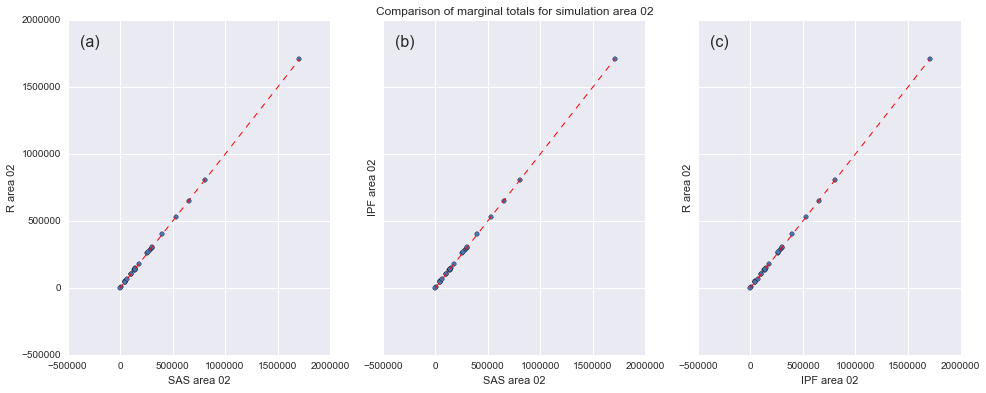

In [36]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)
TAE.plot(kind="scatter", x="SAS area 02", y="R area 02", ax = ax1)
x1 = np.arange(min(TAE["SAS area 02"]), max(TAE["SAS area 02"]), 10)
ax1.text(0.05, 0.92, "(a)", fontsize=16, transform = ax1.transAxes)
ax1.plot(x1, x1, linestyle='--', color="red", linewidth=1)
TAE.plot(kind="scatter", x="SAS area 02", y="IPF area 02", ax = ax2)
x2 = np.arange(min(TAE["SAS area 02"]), max(TAE["SAS area 02"]), 10)
ax2.plot(x2, x2, linestyle='--', color="red", linewidth=1)
ax2.text(0.05, 0.92, "(b)", fontsize=16, transform = ax2.transAxes)
TAE.plot(kind="scatter", x="IPF area 02", y="R area 02", ax = ax3)
x3 = np.arange(min(TAE["IPF area 02"]), max(TAE["IPF area 02"]), 10)
ax3.plot(x3, x3, linestyle='--', color="red", linewidth=1)
ax3.text(0.05, 0.92, "(c)", fontsize=16, transform = ax3.transAxes)
title = 'Comparison of marginal totals for simulation area 02'
ax2.set_title(title)
plt.savefig("FIGURES/marginaltot02.pdf", format="pdf", bbox_inches='tight')

**Figure 2:** Comparison between marginal sums of the **SAS** and **R** implementations and **IPF** for simulation area 02.

## 4.2 Comparison of marginal totals between simulations and census data (TAE)

In [37]:
#for acode in area_codes:
#    sns.jointplot("{}".format(acode),
#                  "R area {}".format(acode),
#                   TAE, kind="reg", color="seagreen");

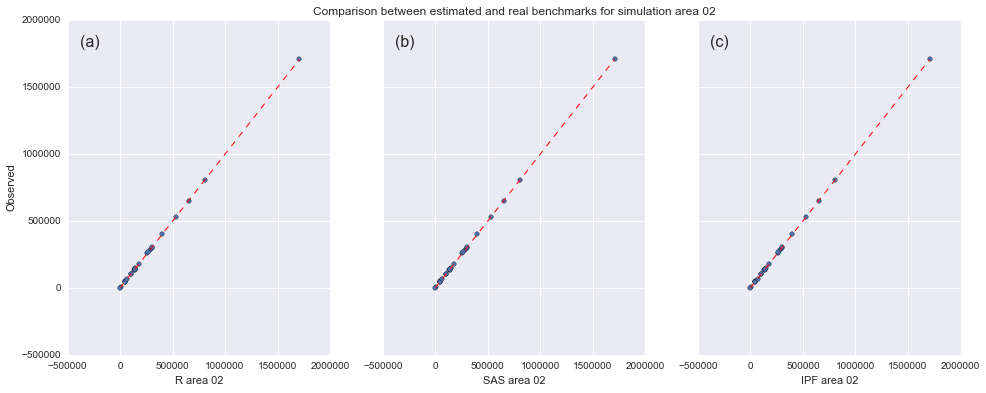

In [38]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)
TAE.plot(kind="scatter", x="R area 02", y="02", ax=ax1)
TAE.plot(kind="scatter", x="SAS area 02", y="02", ax=ax2)
TAE.plot(kind="scatter", x="IPF area 02", y="02", ax=ax3)
x1 = np.arange(min(TAE["R area 02"]), max(TAE["R area 02"]), 10)
ax1.plot(x1, x1, linestyle='--', color="red", linewidth=1)
ax2.plot(x1, x1, linestyle='--', color="red", linewidth=1)
ax3.plot(x1, x1, linestyle='--', color="red", linewidth=1)
ax1.text(0.05, 0.92, "(a)", fontsize=16, transform = ax1.transAxes)
ax2.text(0.05, 0.92, "(b)", fontsize=16, transform = ax2.transAxes)
ax3.text(0.05, 0.92, "(c)", fontsize=16, transform = ax3.transAxes)
ax1.set_ylabel("Observed")
ax2.set_ylabel("")
ax3.set_ylabel("")
title = 'Comparison between estimated and real benchmarks for simulation area 02'
ax2.set_title(title)
plt.savefig("FIGURES/marginaltotTAE.pdf", format="pdf", bbox_inches='tight')

**Figure 3:** Comparison between simulated marginal sums and census constrains for: (a) the **R** implementation of the GREGWT algorithm; (b) the **SAS** macros; and (c) **IPF**.

## 4.3 Total absolute error of the R and SAS implementations

In [39]:
TAE_val = pd.DataFrame(index=TAE.index)
for language in ["R", "SAS", "IPF"]:
    for area in area_codes:
        TAE_val["{} area {}".format(language, area)] = abs(TAE["{} area {}".format(language, area)] - TAE[area])

In [40]:
TAE_val.head()

,R area 02,R area 11,R area 4011,R area 4012,SAS area 02,SAS area 11,SAS area 4011,SAS area 4012,IPF area 02,IPF area 11,IPF area 4011,IPF area 4012
Under.3,2.182787e-11,4.365575e-11,1.818989e-12,9.094947e-13,1.631997e-08,7.679046e-08,38.352358,1.018634e-10,5.760375,21.280306,5.914031,2.444455
3...5,8.003553e-11,2.910383e-11,5.456968e-12,1.364242e-12,1.081207e-08,4.858884e-08,22.893858,2.998604e-09,0.158251,0.577320,0.141947,0.065376
6...14,3.201421e-10,2.328306e-10,5.093170e-11,5.456968e-12,3.899913e-09,2.170564e-07,43.489107,7.405106e-09,0.460000,1.591777,0.459492,0.206630
15...17,7.275958e-12,4.365575e-11,2.182787e-11,1.364242e-12,4.416506e-09,3.541936e-08,14.151112,1.098670e-09,0.146668,0.489733,0.161116,0.074110
18...24,2.619345e-10,2.328306e-10,1.527951e-10,1.455192e-11,6.318442e-08,4.784670e-08,82.028325,4.676622e-09,0.480309,1.806173,0.551152,0.215357


**Table 6:** Computed $TAE$ for individual benchmarks for all simulation.

In [41]:
TAE_val.index = ["const{:02d}".format(i) + "_" + e for i, e in enumerate(TAE_val.index)]

In [42]:
TAE_val.to_csv("TAE.csv")

### 4.3.1 Total absolute error $TAE$ of the individual constrains for the diffrent simulations

In [43]:
len(TAE_val.index.tolist())

24

In [44]:
TAE_val.shape[0]

24

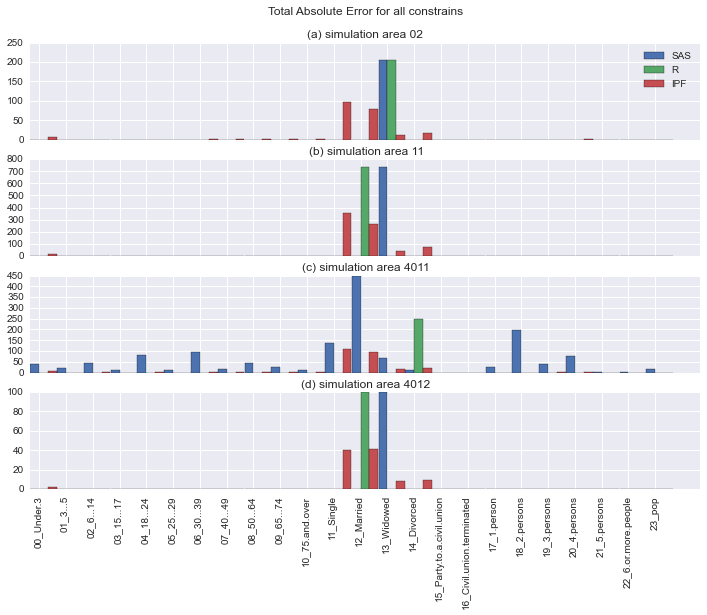

In [45]:
xlab = [a.replace("const", "") for a in TAE_val.index.tolist()]
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
ind = np.arange(TAE_val.shape[0])
width = 0.33

rects1 = ax1.bar(ind, TAE_val["SAS area 02"], width, color=colors[0])
rects2 = ax1.bar(ind+width, TAE_val["R area 02"], width, color=colors[1])
rects3 = ax1.bar(ind+width+width, TAE_val["IPF area 02"], width, color=colors[2])
ax1.set_title('Total Absolute Error for all constrains\n\n(a) simulation area 02')

rects1 = ax2.bar(ind, TAE_val["SAS area 11"], width, color=colors[0])
rects2 = ax2.bar(ind+width, TAE_val["R area 11"], width, color=colors[1])
rects3 = ax2.bar(ind+width+width, TAE_val["IPF area 11"], width, color=colors[2])
ax2.set_title('(b) simulation area 11')

rects1 = ax3.bar(ind, TAE_val["SAS area 4011"], width, color=colors[0])
rects2 = ax3.bar(ind+width, TAE_val["R area 4011"], width, color=colors[1])
rects3 = ax3.bar(ind+width+width, TAE_val["IPF area 4011"], width, color=colors[2])
ax3.set_title('(c) simulation area 4011')

rects1 = ax4.bar(ind, TAE_val["SAS area 4012"], width, color=colors[0])
rects2 = ax4.bar(ind+width, TAE_val["R area 4012"], width, color=colors[1])
rects3 = ax4.bar(ind+width+width, TAE_val["IPF area 4012"], width, color=colors[2])
ax4.set_title('(d) simulation area 4012')

ax4.set_xticks(ind + width)
ax4.set_xticklabels( xlab )

ax1.legend( (rects1[0], rects2[0], rects3[0]), ('SAS', 'R', 'IPF') )
plt.xticks(rotation=90);
plt.savefig("FIGURES/TAE02.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

**Figure 4:** Total Absolute Error for all constrains for all simulations.

### 4.3.2 Sum of the total absolute error $TAE$ for all simulation areas

In [46]:
tuples = [(i.split(" ")[0], i.split(" ")[-1]) for i in TAE_val.columns.tolist()]
index = pd.MultiIndex.from_tuples(tuples, names=['implementation', 'area'])

In [47]:
TAE_sum = pd.DataFrame({"sumTAE":TAE_val.sum().tolist()}, index=index)
TAE_sum

sumTAE
implementation area             
R              02     206.000000
               11     739.000000
               4011   247.000000
               4012   100.000000
SAS            02     206.000002
               11     739.000004
               4011  1435.344196
               4012   100.000000
IPF            02     219.425104
               11     788.027313
               4011   260.792200
               4012   105.650207

**Table 7:** Sum of the $TAE$ for all areas and both implementations of the GREGWT algorithm.

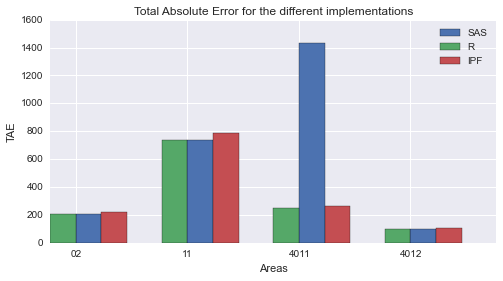

In [50]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
ind = np.arange(4)
width = 0.23
rects1 = ax1.bar(ind+width, TAE_sum.loc[["SAS"],"sumTAE"].tolist(), width, color=colors[0])
rects2 = ax1.bar(ind, TAE_sum.loc[["R"],"sumTAE"].tolist(), width, color=colors[1])
rects3 = ax1.bar(ind+width+width, TAE_sum.loc[["IPF"],"sumTAE"].tolist(), width, color=colors[2])

ax1.set_xticks(ind + width)
ax1.set_xticklabels( ["02", "11", "4011", "4012"] )

ax1.set_ylabel("TAE")
ax1.set_xlabel("Areas")

ax1.legend( (rects1[0], rects2[0], rects3[0]), ('SAS', 'R', 'IPF') )
#plt.xticks(rotation=90);

ax1.set_title('Total Absolute Error for the different implementations')
plt.savefig("FIGURES/TAE03.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

**FIGURE 5:** Sum of the $TAE$ for all areas and all simulations.

# 5. Percentage Absolute Error

The *Standardized absolute error* $SAE$ aims to make the $TAE$ measure comparable between simulation which
normally use different samples for the simulation. The *Percentage Absolute Error* $PSAE$ is the same measure as the $SAE$ measure but express its result as a percentage value.

$$
PSAE = \sum_i^n |Tx - \hat{t}x| \div pop_i \times 100
$$

In [52]:
population_totals = pd.DataFrame(
    {"Age":census.loc[:,"Under.3":"75.and.over"].sum(axis=1),
     "Marital.Status":census.loc[:,"Single":"Civil.union.terminated"].sum(axis=1),
     "Household.Size":census.loc[:,"1.person":"6.or.more.people"].sum(axis=1)})
population_totals["mean"] = population_totals.mean(axis=1)

In [53]:
population_totals

,Age,Household.Size,Marital.Status,mean
Area.Code,,,,
2,1706696,1668910,1706490,1694032.000000
11,3292365,3245207,3291626,3276399.333333
4011,542707,533355,542460,539507.333333
4012,108156,106603,108056,107605.000000


**Table 8:** Estimated population totals for each simulation area.

For the computation of the $PSAE$ error I use the estimated total population from benchmark `age` as this value is the one used in the re-weighting process for both implementations.

In [54]:
PSAE = pd.DataFrame(index=TAE_val.index)
for language in ["R", "SAS", "IPF"]:
    for area in area_codes:
        psae_val = TAE_val["{} area {}".format(language, area)] / population_totals.loc[int(area), "Age"] * 100
        PSAE["{} area {}".format(language, area)] = psae_val

In [56]:
PSAE.to_csv("PSAE.csv")

## 5.1 Percentage absolute error $PSAE$ for the different simulations

In [57]:
PSAE.index = [i.split("_")[-1] for i in PSAE.index]

In [58]:
from matplotlib.ticker import FormatStrFormatter

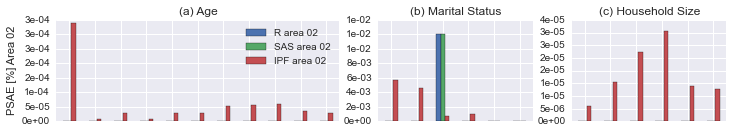

In [59]:
#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[11, 6, 6]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

PSAE.ix[:11,["02" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax1, title="(a) Age")
PSAE.ix[11:17,["02" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax2, title="(b) Marital Status", legend=False)
PSAE.ix[17:-1,["02" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax3, title="(c) Household Size", legend=False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
#ax1.set_xticks("")
ax1.set_xticklabels("")
ax2.set_xticklabels("")
ax3.set_xticklabels("")
ax1.set_ylabel("PSAE [%] Area 02")

plt.savefig("FIGURES/PSAEcat1.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

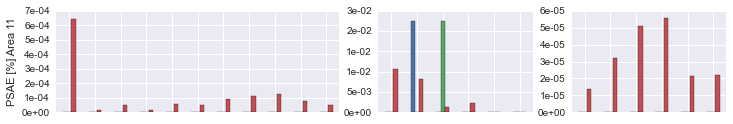

In [60]:
#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[11, 6, 6]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

PSAE.ix[:11,[("11" in i and not "4011" in i) for i in PSAE.columns]].plot(
    kind='bar', ax=ax1, legend=False)
PSAE.ix[11:17,[("11" in i and not "4011" in i) for i in PSAE.columns]].plot(
    kind='bar', ax=ax2, legend=False)
PSAE.ix[17:-1,[("11" in i and not "4011" in i) for i in PSAE.columns]].plot(
    kind='bar', ax=ax3, legend=False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax1.set_ylabel("PSAE [%] Area 11")
ax1.set_xticklabels("")
ax2.set_xticklabels("")
ax3.set_xticklabels("")

plt.savefig("FIGURES/PSAEcat2.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

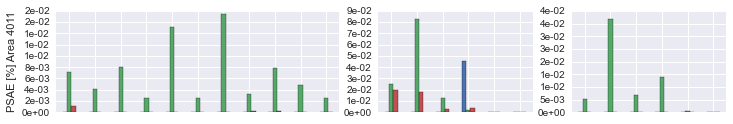

In [61]:
#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[11, 6, 6]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

PSAE.ix[:11,["4011" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax1, legend=False)
PSAE.ix[11:17,["4011" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax2, legend=False)
PSAE.ix[17:-1,["4011" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax3, legend=False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
#ax1.set_xticks("")
ax1.set_xticklabels("")
ax2.set_xticklabels("")
ax3.set_xticklabels("")
ax1.set_ylabel("PSAE [%] Area 4011")

plt.savefig("FIGURES/PSAEcat3.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

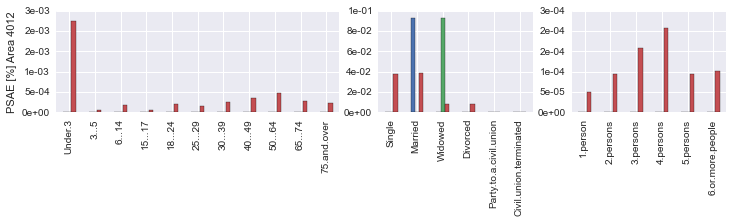

In [62]:
f = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[11, 6, 6]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

PSAE.ix[:11,["4012" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax1, legend=False)
PSAE.ix[11:17,["4012" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax2, legend=False)
PSAE.ix[17:-1,["4012" in i for i in PSAE.columns]].plot(
    kind='bar', ax=ax3, legend=False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%0.0e'))
#ax1.set_xticks("")
#ax1.set_xticklabels("")
#ax2.set_xticklabels("")
#ax3.set_xticklabels("")
ax1.set_ylabel("PSAE [%] Area 4012")

plt.savefig("FIGURES/PSAEcat4.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

## 5.2 Comparison of the sum of the percentage absolute error $PSAE$

In [63]:
PSAE_sum = pd.DataFrame(["{:E}".format(psae) for psae in PSAE.sum()], columns=["PSAE"])
PSAE_sum.index = PSAE.columns

**Table 13:** Sum of the percentage absolute error $PSAE$ for all simulation areas.

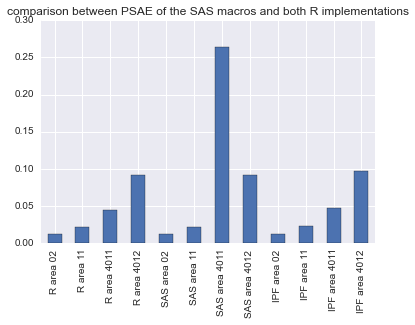

In [64]:
PSAE.sum().plot(kind="bar");
title = "comparison between PSAE of the SAS macros and both R implementations"
plt.title(title);
plt.savefig("FIGURES/sumPSAE02.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

**Figure 7:** Comparison between $PSAE$ of the **SAS** macros and the **R** implementation.

In [65]:
pd.DataFrame(PSAE.sum(), columns=["PSAE"])

,PSAE
R area 02,0.012070
R area 11,0.022446
R area 4011,0.045513
R area 4012,0.092459
SAS area 02,0.012070
SAS area 11,0.022446
SAS area 4011,0.264479
SAS area 4012,0.092459
IPF area 02,0.012857
IPF area 11,0.023935


In [73]:
PSAE_sum = PSAE.sum()
PSAE_sum = pd.DataFrame({
        "GREGWT-R": [PSAE_sum.loc[[("R" in i) for i in PSAE_sum.index]].sum()],
        "IPF-R": [PSAE_sum.loc[[("IPF" in i) for i in PSAE_sum.index]].sum()],
        #"GREGWT-SAS": [PSAE_sum.loc[[("SAS" in i) for i in PSAE_sum.index]].sum()]
    }, index=["PSAE"])

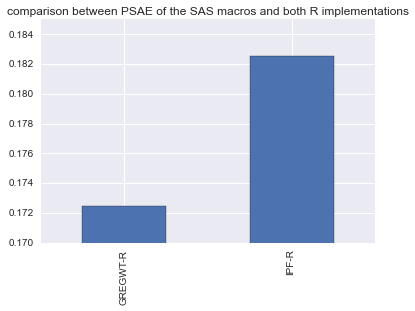

In [75]:
ax = PSAE_sum.sum().plot(kind="bar", ylim=[0.17, 0.185]);
title = "comparison between PSAE of the SAS macros and both R implementations"
plt.title(title);
plt.savefig("FIGURES/sumPSAE03.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

**Figure 8:** Comparison between the sum of $PSAE$ of the **SAS** macros and the **R** implementation.

In [68]:
PSAE_sum.T

,PSAE
GREGWT-R,0.172488
GREGWT-SAS,0.391454
IPF-R,0.182529
